In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Load the data
def load_data():
    with np.load("notMNIST.npz") as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target


def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test

In [78]:
def shuffle(data, target):
  np.random.seed(421)
  rand_idx = np.random.permutation(len(data))
  return data[rand_idx], target[rand_idx]


# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def relu(x):
  return np.clip(x, 0, None)

# input (N, 10)
# output (N, 10)
def softmax(x):
  predict = x - x.max(axis=1, keepdims=True)
  return np.exp(predict) / np.exp(predict).sum(axis=1, keepdims=True)

def compute_layer(x, w, b):
  return x @ w + b

def average_ce(target, prediction):

  mult = target * np.log(prediction)
  sum = np.sum(mult, axis=1)
  return - np.mean(sum)

# compute the derivative of loss with respect to o
# return (N, 10) matrix
def grad_ce(target, predict):
  return predict - target

def back_propagation(x, y, w_o, b_o, w_h, b_h, h, predict):
  # (K, N) @ (N, 10) = (K, 10)
  do = grad_ce(y, predict)
  dw_o = np.transpose(h) @ do / y.shape[0]

  # (1, N) @ (N, 10) = (1, 10)
  one = np.ones((1, y.shape[0]))
  db_o = one @ do / y.shape[0]

  # (N, K)
  dRelu = h
  dRelu[dRelu > 0] = 1

  # (784, N) @ ((N, 10) @ (10, K) * (N, K)) = (784, K)
  dw_h = np.transpose(x) @ (do @ np.transpose(w_o) * dRelu) / y.shape[0]
  
  # (1, N) @ ((N, 10) @ (10, K) * (N, K)) = (1, K)
  one = np.ones((1, x.shape[0]))
  db_h = one @ (do @ np.transpose(w_o) * dRelu) / y.shape[0]

  return dw_o, db_o, dw_h, db_h

def accuracy(y, predict):
  max_predict = np.argmax(predict, axis=1)
  max_y = np.argmax(y, axis=1)
  return (max_predict == max_y).mean()

# plot
def plot_loss(train_loss, valid_loss):

  plt.figure()
  plt.plot(train_loss, label='Training Loss')
  plt.plot(valid_loss, label='Validation Loss')
  title = "Traing & Validation Loss vs epochs"
  plt.title(title)
  plt.xlabel("epoches")
  plt.ylabel("loss")
  plt.legend()
  plt.draw()

  return

def plot_accuracy(train_accuracy, valid_accuracy):

  plt.figure()
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(valid_accuracy, label='Validation Accuracy')
  title = "Traing & Validation Accuracy vs epochs"
  plt.title(title)
  plt.xlabel("epoches")
  plt.ylabel("accuracy")
  plt.legend()
  plt.draw()

  return 

In [79]:
# load and parse data
train_data, valid_data, test_data, train_target, valid_target, test_target = load_data()
new_train, new_valid, new_test = convert_onehot(train_target, valid_target, test_target)
train_data = train_data.reshape(10000, -1)
valid_data = valid_data.reshape(6000, -1)

# shuffle
train_data, new_train = shuffle(train_data, new_train)

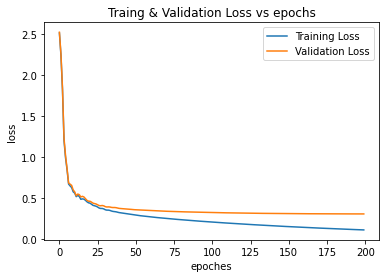

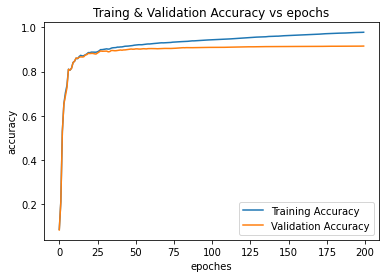

In [81]:
# initialize weights and biases
w_h = np.random.normal(0, 0.0335, (784, 1000))
w_o = np.random.normal(0, 0.0445, (1000, 10))
v_wh = np.full((784, 1000), 10**-5)
v_wo = np.full((1000, 10), 10**-5)
b_h = np.zeros((1, 1000))
b_o = np.zeros((1, 10))
v_bh = np.full((1, 1000), 10**-5)
v_bo = np.full((1, 10), 10**-5)

# container for plotting
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

# main
for i in range(200):
  # calculate predictions
  train_h = relu(compute_layer(train_data, w_h, b_h))
  train_o = compute_layer(train_h, w_o, b_o)
  train_predict = softmax(train_o)

  valid_h = relu(compute_layer(valid_data, w_h, b_h))
  valid_o = compute_layer(valid_h, w_o, b_o)
  valid_predict = softmax(valid_o)

  # calculate loss and accuracy
  train_loss.append(average_ce(new_train, train_predict))
  valid_loss.append(average_ce(new_valid, valid_predict))
  train_accuracy.append(accuracy(new_train, train_predict))
  valid_accuracy.append(accuracy(new_valid, valid_predict))

  # do gradient descent
  dw_o, db_o, dw_h, db_h = back_propagation(train_data, new_train, w_o, b_o, w_h, b_h, train_h, train_predict)
  v_wo = 0.9 * v_wo + 0.1 * dw_o
  v_bo = 0.9 * v_bo + 0.1 * db_o
  v_wh = 0.9 * v_wh + 0.1 * dw_h
  v_bh = 0.9 * v_bh + 0.1 * db_h

  w_o -= v_wo
  w_h -= v_wh
  b_o -= v_bo
  b_h -= v_bh
plot_loss(train_loss, valid_loss)
plot_accuracy(train_accuracy, valid_accuracy)